# Learning Encodes Alignment within a Protein Family.

In [21]:
# Needed to import modules from helpers
import sys
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import random
import gzip
import urllib.request # TODO: Outsource data download to helper script

import esm
from io import StringIO
from Bio import SeqIO
from Bio import AlignIO

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from helpers import helper

from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# Load ESM model to GPU

In [3]:
# kleineres Modell 'esm2_t6_8M_UR50D' zum testen 
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

# Get Data

### Hypothesis 1:
Final hidden representations of a sequence encode information about the MSA it belongs to. Even if it never saw the MSA (Model learns to cluster sequences belonging to the same MSA together). MSA is a long expensive process which could be improved by this model.

### Method:

- Get Dataset (Pfam)
- compare the distribution of cosine similarities of representations between pairs of residues that are aligned in the family’s MSA background distribution of cosine similarities between unaligned pairs of residues.
- Compare with distributions befor learning (We need the embeddings befor pretraining (randomize model))
From paper: -	Using the collection of MSAs of structurally related sequences in Pfam (48), we compare the distribution of cosine similarities of representations between pairs of residues that are aligned in the family’s MSA to a background distribution of cosine similarities between unaligned pairs of residues


In [4]:
# Fetch the data. PF01010 (Response regulator receiver domain)
msa_data = helper.get_pfam_seed_by_id("PF01010")

if msa_data:
    # Parse using BioPython
    msa = AlignIO.read(StringIO(msa_data), "stockholm")
    
    # Verify
    print(f"\nSuccess! Loaded {msa[0].id}")
    print(f"Sequence count: {len(msa)}")
    print(f"Alignment length: {msa.get_alignment_length()}")
else:
    print("Family not found in the current Pfam release.")

Streaming Pfam database to find PF01010...
This may take 1-2 minutes as it searches the compressed stream.

Success! Loaded Q8HUX0_9ROSA/106-348
Sequence count: 76
Alignment length: 344


In [11]:
# Assuming your alignment object is named 'alignment'
# We extract the ID and convert the Seq object to a string
data = [{'id': record.id, 'sequence': str(record.seq)} for record in msa]

df = pd.DataFrame(data)

# Preview
print(df.head())

                     id                                           sequence
0  Q8HUX0_9ROSA/106-348  RIYLLTFEGHLN------VHFQTYSGK--KNNLF--SSISLWG--K...
1   Q0MS80_9ROSA/77-329  RIYLLAFEGHLN------VYFQTYSGK--KSSSF--YSMSLWGKDK...
2  Q6JXE4_9ROSA/410-658  RIYLLTFEGHLN------VYCKTYSGK--KKRSV--YSISLWG--R...
3  Q6JX94_9ROSA/404-655  RIYLLTFEGHLN------FYFQTYSDK--KRSSV--YSISLWG--R...
4    NU5C_PELHO/448-688  RIYLLTFEGHLN------VHFRNYSGK--RSNSF--YSISLWG--N...


In [ ]:
# Create a list where every sequence string is split into a list of characters
data = [list(str(record.seq)) for record in msa]

# Pass the IDs as the index
ids = [record.id for record in msa]

df = pd.DataFrame(data, index=ids)

# This results in columns 0 to 343 (since length is 344)
print(df.head())

                     0   1   2   3   4   5   6   7   8   9    ... 334 335 336  \
Q8HUX0_9ROSA/106-348   R   I   Y   L   L   T   F   E   G   H  ...   K   L   A   
Q0MS80_9ROSA/77-329    R   I   Y   L   L   A   F   E   G   H  ...   R   L   A   
Q6JXE4_9ROSA/410-658   R   I   Y   L   L   T   F   E   G   H  ...   L   F   S   
Q6JX94_9ROSA/404-655   R   I   Y   L   L   T   F   E   G   H  ...   I   L   S   
NU5C_PELHO/448-688     R   I   Y   L   L   T   F   E   G   H  ...   G   F   A   

                     337 338 339 340 341 342 343  
Q8HUX0_9ROSA/106-348   Q   L   T   H   F   F   D  
Q0MS80_9ROSA/77-329    E   L   T   H   F   F   D  
Q6JXE4_9ROSA/410-658   E   I   I   N   I   L   D  
Q6JX94_9ROSA/404-655   K   L   I   H   F   F   D  
NU5C_PELHO/448-688     E   F   T   H   F   F   D  

[5 rows x 344 columns]


### Prepare Data: Map MSA columns to Sequence Indices
The model cannot handle gaps ('.' or '-'), so we must remove them.
However, to check if residues are "aligned", we need to know their original column index.

In [15]:
clean_seqs = []
msa_mapping = [] # List of dictionaries: {msa_column_index: sequence_residue_index}

print(f"Processing {len(msa)} sequences...")

for record in msa:
    original_seq = str(record.seq)
    clean_seq = ""
    mapping = {}
    
    seq_idx = 0
    for msa_idx, char in enumerate(original_seq):
        # Pfam uses '.' and '-' for gaps. We only want amino acids.
        if char not in ['.', '-']:
            clean_seq += char
            # Record that this MSA column corresponds to this index in the clean sequence
            mapping[msa_idx] = seq_idx 
            seq_idx += 1
            
    clean_seqs.append(clean_seq)
    msa_mapping.append(mapping)

print(f"First clean sequence (len {len(clean_seqs[0])}): {clean_seqs[0][:20]}...")

Processing 76 sequences...
First clean sequence (len 243): RIYLLTFEGHLNVHFQTYSG...


### 2. Get Representations (Forward Pass)

In [20]:
# A. Trained Model
print("Running forward pass on TRAINED model...")
# Note: We use the helper, but we pass the labels=None explicitly if your helper expects it
with torch.no_grad():
    token_reps_trained, batch_strs_trained = helper.get_hidden_representations(
        model, alphabet, np.zeros_like(clean_seqs), clean_seqs
    )

# B. Untrained Model (Random Baseline)
print("Running forward pass on UNTRAINED model...")
# Create a randomized version of the model to test the "Emergence" hypothesis
untrained_model = helper.randomize_model(model)
if torch.cuda.is_available(): 
    untrained_model = untrained_model.cuda()
    
with torch.no_grad():
    token_reps_untrained, batch_strs_untrained = helper.get_hidden_representations(
        untrained_model, alphabet, np.zeros_like(clean_seqs), clean_seqs
    )

print("Forward passes complete.")

Running forward pass on TRAINED model...
Processing 76 sequences in batches of 1...
Running forward pass on UNTRAINED model...
Processing 76 sequences in batches of 1...
Forward passes complete.


### 3. Calculate Cosine Similarities

In [22]:
def get_cosine_sims(token_reps, mapping_list, msa_length, num_samples=5000):
    aligned_sims = []
    unaligned_sims = []
    
    num_seqs = len(token_reps)
    
    # --- Sampling Aligned Pairs ---
    # Pick a random column in the MSA, find two sequences that both have a residue there.
    attempts = 0
    while len(aligned_sims) < num_samples and attempts < num_samples * 5:
        attempts += 1
        col_idx = random.randint(0, msa_length - 1)
        
        # Pick two random sequences
        seq_a_idx = random.randint(0, num_seqs - 1)
        seq_b_idx = random.randint(0, num_seqs - 1)
        
        if seq_a_idx == seq_b_idx: continue
            
        # Check if both sequences have a residue at this MSA column (no gap)
        map_a = mapping_list[seq_a_idx]
        map_b = mapping_list[seq_b_idx]
        
        if col_idx in map_a and col_idx in map_b:
            # Get the embeddings for these specific residues
            # Note: token_reps includes <cls> at 0, so we add 1 to the mapped index
            emb_a = token_reps[seq_a_idx][map_a[col_idx] + 1].cpu().numpy()
            emb_b = token_reps[seq_b_idx][map_b[col_idx] + 1].cpu().numpy()
            
            sim = cosine_similarity(emb_a.reshape(1, -1), emb_b.reshape(1, -1))[0][0]
            aligned_sims.append(sim)

    # --- Sampling Unaligned Pairs ---
    # Pick two random sequences and two DIFFERENT random columns.
    attempts = 0
    while len(unaligned_sims) < num_samples and attempts < num_samples * 5:
        attempts += 1
        
        seq_a_idx = random.randint(0, num_seqs - 1)
        seq_b_idx = random.randint(0, num_seqs - 1)
        
        # Select random valid positions in the clean sequences
        len_a = len(token_reps[seq_a_idx]) - 2 # minus cls/eos
        len_b = len(token_reps[seq_b_idx]) - 2
        
        if len_a < 1 or len_b < 1: continue

        pos_a = random.randint(1, len_a)
        pos_b = random.randint(1, len_b)
        
        emb_a = token_reps[seq_a_idx][pos_a].cpu().numpy()
        emb_b = token_reps[seq_b_idx][pos_b].cpu().numpy()
        
        sim = cosine_similarity(emb_a.reshape(1, -1), emb_b.reshape(1, -1))[0][0]
        unaligned_sims.append(sim)
            
    return np.array(aligned_sims), np.array(unaligned_sims)

# Calculate for Trained
print("Calculating similarities for TRAINED model...")
msa_len = msa.get_alignment_length()
train_aligned, train_unaligned = get_cosine_sims(token_reps_trained, msa_mapping, msa_len)

# Calculate for Untrained
print("Calculating similarities for UNTRAINED model...")
untrain_aligned, untrain_unaligned = get_cosine_sims(token_reps_untrained, msa_mapping, msa_len)

print(f"Done. Collected {len(train_aligned)} aligned and {len(train_unaligned)} unaligned pairs.")

Calculating similarities for TRAINED model...
Calculating similarities for UNTRAINED model...
Done. Collected 5000 aligned and 5000 unaligned pairs.


### Visualization

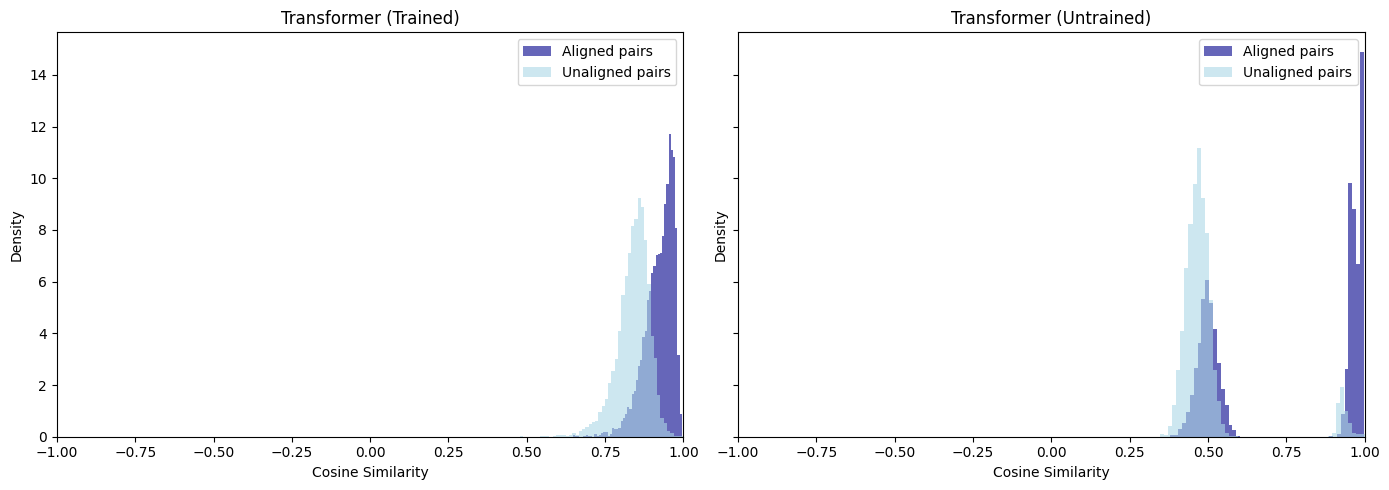

AUC Score (Discrimination between Aligned/Unaligned):
Trained Model:   0.8932
Untrained Model: 0.8606


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot Helper
def plot_dist(ax, aligned, unaligned, title):
    # Plot histograms with density
    ax.hist(aligned, bins=50, density=True, alpha=0.6, color='darkblue', label='Aligned pairs')
    ax.hist(unaligned, bins=50, density=True, alpha=0.6, color='lightblue', label='Unaligned pairs')
    ax.set_title(title)
    ax.set_xlabel("Cosine Similarity")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_xlim(-1, 1)

# Plot Trained
plot_dist(axes[0], train_aligned, train_unaligned, "Transformer (Trained)")

# Plot Untrained
plot_dist(axes[1], untrain_aligned, untrain_unaligned, "Transformer (Untrained)")

plt.tight_layout()
plt.show()

# --- Evaluation (AUC) ---
# Quantify the separation between the distributions
def get_auc(aligned, unaligned):
    y_true = [1] * len(aligned) + [0] * len(unaligned)
    y_scores = np.concatenate([aligned, unaligned])
    return roc_auc_score(y_true, y_scores)

auc_trained = get_auc(train_aligned, train_unaligned)
auc_untrained = get_auc(untrain_aligned, untrain_unaligned)

print(f"AUC Score (Discrimination between Aligned/Unaligned):")
print(f"Trained Model:   {auc_trained:.4f}")
print(f"Untrained Model: {auc_untrained:.4f}")